***Portfolio formation for levered portfolio returns***

In [19]:
'''
lev_multiplier = 0.697634461217614
limit = 0.0005
# lev_multiplier = 0
closed_trades = []
for date in dates:
    model_size = model_swap_rates[model_swap_rates['date2'] == date].size
    swap_size = data1_swap_trade[data1_swap_trade['date2'] == date].size
    data1_libor_3M_original_size = data1_libor_3M_original[data1_libor_3M_original['date2'] == date].size
    weight_size = weight_data[weight_data['date2'] == date].size
    if model_size != 0 and swap_size != 0 and data1_libor_3M_original_size != 0 and weight_size != 0:
        long_date = data1_swap_trade[data1_swap_trade['date2']==date].values[0][0]
        temp_book = pt.update_book(temp_book, data1_libor_3M_original, data1_swap_trade, date)
        temp_book = pt.add_to_book(date, temp_book, model_swap_rates, data1_swap_trade, data1_libor_3M_original, weight_data, limit, 100*lev_multiplier, 3, 6)
        temp_book = pt.update_current_dirty_prices(long_date, temp_book, cub_libor, cub_swap, cub_ois, "Act/360", "30/360", 3, 6)
        book_dict[date] = temp_book
        temp_book, closes_maturity = pt.clean_book_maturity(temp_book)
        temp_book, closes_convergence = pt.clean_book_convergence(temp_book)
        closed_trades.append([date, closes_convergence + closes_maturity])
        temp_book = pt.update_latest_dirty_prices(long_date, temp_book, cub_libor, cub_swap, cub_ois, "Act/360", "30/360", 3, 6)
    else:
        #long_date = data1_libor_3M_original[data1_libor_3M_original['date2']==date].values[0][0] # poista
        temp_book = pt.update_book2(temp_book, data1_libor_3M_original, date)
        #temp_book = pt.update_current_dirty_prices(long_date, temp_book, cub_libor, cub_swap, cub_ois, "Act/360", "30/360", 3, 6) # poista
        book_dict[date] = temp_book
        temp_book, closes_maturity = pt.clean_book_maturity(temp_book)
        temp_book, closes_convergence = pt.clean_book_convergence(temp_book)
        closed_trades.append([date, closes_convergence + closes_maturity])
        #temp_book = pt.update_latest_dirty_prices(long_date, temp_book, cub_libor, cub_swap, cub_ois, "Act/360", "30/360", 3, 6) # poista
closed_trades_df = pd.DataFrame(closed_trades, columns=['date','closed count'])
'''

In [61]:
'''
closed_trades = []
limit = 0.002
nominal = 100
step_float = 3
step_fixed = 6
conv_float = "Act/360"
conv_fixed = "30/360"
for date in dates:
    model_size = model_swap_rates[model_swap_rates['date2'] == date].size
    swap_size = data1_swap_trade[data1_swap_trade['date2'] == date].size
    data1_libor_3M_original_size = data1_libor_3M_original[data1_libor_3M_original['date2'] == date].size
    weight_size = weight_data[weight_data['date2'] == date].size
    if model_size != 0 and swap_size != 0 and data1_libor_3M_original_size != 0 and weight_size != 0:
        long_date = data1_swap_trade[data1_swap_trade['date2']==date].values[0][0]
        temp_book = pt.update_book(temp_book, data1_libor_3M_original, data1_swap_trade, date)
        temp_book = pt.add_to_book(date, temp_book, model_swap_rates, data1_swap_trade, data1_libor_3M_original, weight_data, limit, nominal, step_float, step_fixed)
        temp_book = pt.update_current_dirty_prices(long_date, temp_book, cub_libor, cub_swap, cub_ois, conv_float, conv_fixed, step_float, step_fixed)
        book_dict[date] = temp_book
        temp_book, closes_maturity = pt.clean_book_maturity(temp_book)
        temp_book, closes_convergence = pt.clean_book_convergence(temp_book)
        closed_trades.append([date, closes_convergence + closes_maturity])
        temp_book = pt.update_latest_dirty_prices(long_date, temp_book, cub_libor, cub_swap, cub_ois, conv_float, conv_fixed, step_float, step_fixed)
    else:
        #long_date = data1_libor_3M_original[data1_libor_3M_original['date2']==date].values[0][0] # poista
        temp_book = pt.update_book2(temp_book, data1_libor_3M_original, date)
        #temp_book = pt.update_current_dirty_prices(long_date, temp_book, cub_libor, cub_swap, cub_ois, "Act/360", "30/360", 3, 6) # poista
        book_dict[date] = temp_book
        temp_book, closes_maturity = pt.clean_book_maturity(temp_book)
        temp_book, closes_convergence = pt.clean_book_convergence(temp_book)
        closed_trades.append([date, closes_convergence + closes_maturity])
        #temp_book = pt.update_latest_dirty_prices(long_date, temp_book, cub_libor, cub_swap, cub_ois, "Act/360", "30/360", 3, 6) # poista
closed_trades_df = pd.DataFrame(closed_trades, columns=['date','closed count'])
'''

In [93]:
# Template for limit changes
'''
# "Infrastructure" for creating the dictionary of books
dates = pd.date_range('2015-01', '2022-01', freq='M').to_period('M')
temp_book = pt.create_book()
book_dict = pt.create_dict_of_books()

closed_trades = []
limit = 0.002 # This is changed between 5bps, 10bps and 20bps
nominal = 100
step_float = 3
step_fixed = 6
conv_float = "Act/360"
conv_fixed = "30/360"
for date in dates:
    model_size = model_swap_rates[model_swap_rates['date2'] == date].size
    swap_size = data1_swap_trade[data1_swap_trade['date2'] == date].size
    data1_libor_3M_original_size = data1_libor_3M_original[data1_libor_3M_original['date2'] == date].size
    weight_size = weight_data[weight_data['date2'] == date].size
    if model_size != 0 and swap_size != 0 and data1_libor_3M_original_size != 0 and weight_size != 0:
        long_date = data1_swap_trade[data1_swap_trade['date2']==date].values[0][0]
        temp_book = pt.update_book(temp_book, data1_libor_3M_original, data1_swap_trade, date)
        temp_book = pt.add_to_book(date, temp_book, model_swap_rates, data1_swap_trade, data1_libor_3M_original, weight_data, limit, nominal, step_float, step_fixed)
        temp_book = pt.update_current_dirty_prices(long_date, temp_book, cub_libor, cub_swap, cub_ois, conv_float, conv_fixed, step_float, step_fixed)
        book_dict[date] = temp_book
        temp_book, closes_maturity = pt.clean_book_maturity(temp_book)
        temp_book, closes_convergence = pt.clean_book_convergence(temp_book)
        closed_trades.append([date, closes_convergence + closes_maturity])
        temp_book = pt.update_latest_dirty_prices(long_date, temp_book, cub_libor, cub_swap, cub_ois, conv_float, conv_fixed, step_float, step_fixed)
    else:
        #long_date = data1_libor_3M_original[data1_libor_3M_original['date2']==date].values[0][0] # poista
        temp_book = pt.update_book2(temp_book, data1_libor_3M_original, date)
        #temp_book = pt.update_current_dirty_prices(long_date, temp_book, cub_libor, cub_swap, cub_ois, "Act/360", "30/360", 3, 6) # poista
        book_dict[date] = temp_book
        temp_book, closes_maturity = pt.clean_book_maturity(temp_book)
        temp_book, closes_convergence = pt.clean_book_convergence(temp_book)
        closed_trades.append([date, closes_convergence + closes_maturity])
        #temp_book = pt.update_latest_dirty_prices(long_date, temp_book, cub_libor, cub_swap, cub_ois, "Act/360", "30/360", 3, 6) # poista
closed_trades_df = pd.DataFrame(closed_trades, columns=['date','closed count'])
'''

### Return calculations ###

In [1]:
from matplotlib import pyplot as plt
from statistics import mean
from statistics import stdev
from statistics import median
from scipy.stats import skew
from scipy.stats import kurtosis
from scipy import stats
import pandas as pd
import statsmodels.formula.api as sm
import statsmodels.stats.sandwich_covariance as sw
import numpy as np
import statsmodels as statsmodels
import statsmodels.api as smf
from statsmodels.graphics import tsaplots
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
%run positions.ipynb

2012-01-31T00:00:00.000000000
[0.008687658886465383, 0.0847858484219886, 0.02157110808342321, 0.45131844869147536, 0.005025267035166555, 0.028997398019494032, 0.028514037751278656, -0.03057064010652762, 4.209476176899002e-06, True, 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH']
2012-02-29T00:00:00.000000000
[0.006567135515759778, 0.08484296991968412, 0.020680186829525316, 0.45155484698439985, 0.004733628771493902, 0.029045067915495777, 0.03066731827794569, -0.03319113244408369, 4.2229472173982464e-06, True, 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH']
2012-03-30T00:00:00.000000000
[0.011536253403065083, 0.0847612174986951, 0.02272316816700314, 0.45192338218555084, 0.004711352595866848, 0.028105548177323976, 0.032997321009479184, -0.03614009576224087, 4.469861005861787e-06, True, 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH']
2012-04-30T00:00:00.000000000
[0.0110576664894535, 0.0847901584959873, 0.02243911234131892, 0.4519106212488959, 0.004553927606251328, 0.0280624353280

C:\Users\Miro_\AppData\Local\Temp/ipykernel_22700/1498460402.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data1_libor_3M_original['date2'] =  data1_libor_3M_original['date'].dt.to_period('M')


<AxesSubplot:>

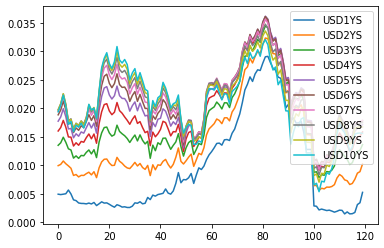

In [3]:
model_swap_rates.loc[:,'USD1YS':].plot()

In [4]:
# closed_trades_df[closed_trades_df['date']=='2013-02'].values[0][1]
closed_trades_df

,date,closed count
0,2012-01,0
1,2012-02,0
2,2012-03,0
3,2012-04,0
4,2012-05,0
...,...,...
115,2021-08,2
116,2021-09,2
117,2021-10,8
118,2021-11,0


In [5]:
book_dict[dates[0]].columns

Index(['date', 'Trade type', 'M from open', 'Maturity', 'M to float',
       'M to fixed', 'S of model', 'S of trade', 'S of H1', 'S of H10',
       'Latest 3ML', 'Previous total dirty', 'Previous trade dirty',
       'Previous H1 dirty', 'Previous H10 dirty', 'Nominal trade',
       'Nominal H1', 'Nominal H10', 'Weight H1', 'Weight H10',
       'Initial mispricing', 'Current mispricing', 'Current total dirty',
       'Current trade dirty', 'Current H1 dirty', 'Current H10 dirty'],
      dtype='object')

In [6]:
# Constants for modifying plots and returns from % to bps and vice versa
bps = 0.0001
bpsmult = 10000

In [7]:
data1_swap_trade.loc[4:,:] #.reset_index(drop=True)

,date,USD1YS,USD2YS,USD3YS,USD4YS,USD5YS,USD6YS,USD7YS,USD8YS,USD9YS,USD10YS,date2
4,2012-01-31,0.00496,0.00517,0.00599,0.00780,0.01003,0.01258,0.01472,0.01656,0.01809,0.01941,2012-01
5,2012-02-29,0.00489,0.00558,0.00684,0.00887,0.01122,0.01364,0.01585,0.01773,0.01923,0.02058,2012-02
6,2012-03-30,0.00496,0.00582,0.00745,0.00983,0.01243,0.01498,0.01736,0.01924,0.02093,0.02234,2012-03
7,2012-04-30,0.00504,0.00550,0.00664,0.00870,0.01101,0.01339,0.01554,0.01745,0.01902,0.02038,2012-04
8,2012-05-31,0.00569,0.00611,0.00677,0.00811,0.00992,0.01169,0.01334,0.01480,0.01608,0.01722,2012-05
...,...,...,...,...,...,...,...,...,...,...,...,...
119,2021-08-31,0.00154,0.00301,0.00528,0.00718,0.00868,0.00996,0.01102,0.01187,0.01257,0.01319,2021-08
120,2021-09-30,0.00176,0.00395,0.00669,0.00903,0.01083,0.01224,0.01335,0.01420,0.01489,0.01548,2021-09
121,2021-10-29,0.00314,0.00702,0.00983,0.01140,0.01246,0.01340,0.01417,0.01477,0.01525,0.01566,2021-10
122,2021-11-29,0.00346,0.00742,0.01034,0.01191,0.01291,0.01376,0.01446,0.01496,0.01534,0.01569,2021-11


In [8]:
model_swap_rates

,date,USD1YS,USD2YS,USD3YS,USD4YS,USD5YS,USD6YS,USD7YS,USD8YS,USD9YS,USD10YS,date2
0,2012-01-31,0.00496,0.009968,0.013534,0.016044,0.017765,0.018881,0.019523,0.019783,0.019730,0.01941,2012-01
1,2012-02-29,0.00489,0.010190,0.013975,0.016652,0.018505,0.019729,0.020464,0.020806,0.020828,0.02058,2012-02
2,2012-03-30,0.00496,0.010778,0.014947,0.017904,0.019957,0.021319,0.022144,0.022540,0.022587,0.02234,2012-03
3,2012-04-30,0.00504,0.010299,0.014055,0.016707,0.018531,0.019723,0.020418,0.020716,0.020686,0.02038,2012-04
4,2012-05-31,0.00569,0.009926,0.012922,0.015007,0.016406,0.017274,0.017721,0.017826,0.017646,0.01722,2012-05
...,...,...,...,...,...,...,...,...,...,...,...,...
115,2021-08-31,0.00154,0.006841,0.010473,0.012877,0.014353,0.015108,0.015284,0.014981,0.014268,0.01319,2021-08
116,2021-09-30,0.00176,0.007583,0.011605,0.014304,0.016008,0.016941,0.017261,0.017077,0.016466,0.01548,2021-09
117,2021-10-29,0.00314,0.008656,0.012447,0.014971,0.016540,0.017368,0.017606,0.017356,0.016691,0.01566,2021-10
118,2021-11-29,0.00346,0.008914,0.012656,0.015141,0.016678,0.017480,0.017694,0.017424,0.016740,0.01569,2021-11


Text(0, 0.5, 'Bps')

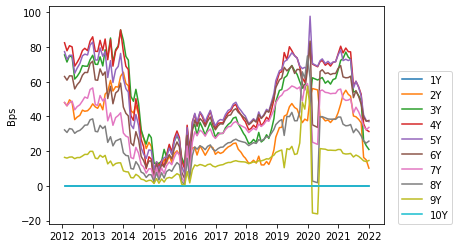

In [9]:
# Plotting the mispricings in basis points
mispricings = model_swap_rates.loc[:,'USD1YS':'USD10YS'].reset_index(drop=True) - data1_swap_trade.loc[4:,'USD1YS':'USD10YS'].reset_index(drop=True)
mispricings = mispricings*bpsmult #Modifying the mispricings to basis points
plt.plot(model_swap_rates['date'], mispricings)
plt.legend(['1Y','2Y','3Y','4Y','5Y','6Y','7Y','8Y','9Y','10Y'], loc=(1.04,0))
plt.ylabel('Bps')
#plt.savefig('final_subp_cir_cobyla_misprices_mod.eps', bbox_inches='tight')

In [11]:
#mispricings.to_excel('misprices_cir_subp.xlsx')

In [104]:
dates

PeriodIndex(['2015-01', '2015-02', '2015-03', '2015-04', '2015-05', '2015-06',
             '2015-07', '2015-08', '2015-09', '2015-10', '2015-11', '2015-12',
             '2016-01', '2016-02', '2016-03', '2016-04', '2016-05', '2016-06',
             '2016-07', '2016-08', '2016-09', '2016-10', '2016-11', '2016-12',
             '2017-01', '2017-02', '2017-03', '2017-04', '2017-05', '2017-06',
             '2017-07', '2017-08', '2017-09', '2017-10', '2017-11', '2017-12',
             '2018-01', '2018-02', '2018-03', '2018-04', '2018-05', '2018-06',
             '2018-07', '2018-08', '2018-09', '2018-10', '2018-11', '2018-12',
             '2019-01', '2019-02', '2019-03', '2019-04', '2019-05', '2019-06',
             '2019-07', '2019-08', '2019-09', '2019-10', '2019-11', '2019-12',
             '2020-01', '2020-02', '2020-03', '2020-04', '2020-05', '2020-06',
             '2020-07', '2020-08', '2020-09', '2020-10', '2020-11', '2020-12',
             '2021-01', '2021-02', '2021-03', '2021-

## Calculating the returns for open trades at each month ##

In [10]:
# Calculating first the monthly pre-trading cost returns by position (open trade)
init_margin = 0.05 * (1/0.48857)
monthly_ret_data = [] # List of tuples: (date, list of returns by position in a month)
for date in dates:
    date_book = book_dict[date]
    date_returns = [] # list of returns by position in a month
    for index, row in date_book.iterrows():
        curr = row[22]
        prev = row[11]
        m_from_open = row[2]
        if m_from_open != 0:
            ret = (curr-prev)/(init_margin*(row[15] + row[16] + row[17])) #unlevered
            #ret = (curr-prev)/(init_margin*(100 + 100*row[18] + 100*row[19])) #levered
            date_returns.append(ret)
    monthly_ret_data.append((date,date_returns))

## Calculating the total (unlevered) portfolio value at each month ##

Text(0, 0.5, '$ - value')

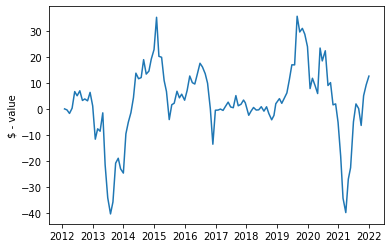

In [11]:
# All trades, total portfolio value
value_data = [] 
for date in dates:
    date_df = book_dict[date]
    curr_data = []
    for index, row in date_df.iterrows():
        curr = row[22]
        curr_data.append(curr)
    sumcurr = sum(curr_data)
    value_data.append(sumcurr)

# Plotting the total portfolio value
plt.plot(model_swap_rates['date'], value_data)
plt.ylabel('$ - value')
#plt.savefig('final_pfoliovalue_subp_cir_cobyla_5bps_mod.eps')

## Calculating the monthly ex-trading cost returns ##

In [12]:
# Calculating first the monthly pre-trading cost mean returns and then subtracting the trading costs of the month
monthly_mean_ret = []
for ret_tuple in monthly_ret_data:
    date = ret_tuple[0]
    returns = ret_tuple[1]
    trade_cost = closed_trades_df[closed_trades_df['date']==date].values[0][1]*bps
    if len(returns) != 0:
        mean_ret = mean(returns)
        mean_ret_trade_cost = mean_ret - trade_cost
        monthly_mean_ret.append(mean_ret_trade_cost)
    else:
        monthly_mean_ret.append(-trade_cost)

Text(0, 0.5, '%')

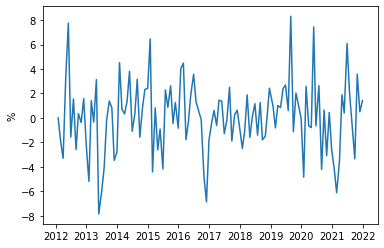

In [13]:
# Modifying ex-trading cost return data to % for plotting
monthly_mean_ret_perc = [ele * 100 for ele in monthly_mean_ret]

# Plotting the monthly ex-trading cost returns
plt.plot(model_swap_rates['date'], monthly_mean_ret_perc)
plt.ylabel('%')
#plt.savefig('final_excostret_subp_cir_cobyla_5bps_mod.eps')

## Calculating the return statistics in basis points ##

***Basic descriptive statistics information on returns***

In [14]:
# Number of observations
len(monthly_mean_ret[1:])

119

In [15]:
# Checking the first monthly return
monthly_mean_ret[0]

-0.0

In [16]:
# Mean of returns in basis points
ret_mean = mean(monthly_mean_ret[1:]) * bpsmult
ret_mean

7.795679938190135

In [17]:
# Monthly stdev of returns
monthly_stdev = stdev(monthly_mean_ret[1:])
monthly_stdev

0.028913597743198235

In [16]:
# Monthly stdev in basis points
monthly_stdev * bpsmult

430.7025628445632

In [18]:
# Annual stdev
ann_stdev = monthly_stdev * np.sqrt(12)
ann_stdev

0.10015964064165633

In [18]:
# Annual stdev in basis points
ann_stdev * bpsmult

1491.9974435938216

In [19]:
# Solving the required leverage ratios
lev_ratio = 0.1/ann_stdev
lev_ratio

0.6702424352626694

In [19]:
# Median of returns in basis points
median(monthly_mean_ret[1:]) * bpsmult

35.02644337213371

In [20]:
# Min of returns in basis points
min(monthly_mean_ret[1:]) * bpsmult

-784.9429347269082

In [21]:
# Max of returns in basis points
max(monthly_mean_ret[1:]) * bpsmult

831.0048970785492

***Sharpe ratio and distribution figures***

In [22]:
# Non-corrected skewness of returns
skew(monthly_mean_ret[1:])

0.0216780966392378

In [23]:
# Non-corrected kurtosis of returns
kurtosis(monthly_mean_ret[1:])

0.7008893972419221

In [24]:
# Sharpe ratio
monthly_sharpe = mean(monthly_mean_ret[1:]) / stdev(monthly_mean_ret[1:])
monthly_sharpe

0.026961985178838653

In [25]:
# Annualized sharpe ratio of returns
monthly_sharpe * np.sqrt(12)

0.09339905640533518

In [26]:
# Ratio of negative returns
sum(1 for i in monthly_mean_ret[1:] if i < 0)/len(monthly_mean_ret[1:])

0.46218487394957986

In [30]:
monthly_mean_ret

[-0.0,
 -0.08918651475804447,
 -0.0,
 0.07247992290501361,
 0.02363314564192477,
 0.12126380971302318,
 -0.06841579619202189,
 -0.028258770220978467,
 -0.07048694839214688,
 0.010362131074195098,
 -0.02821615176903429,
 0.026598820395188242,
 -0.13616271124307566,
 -0.12612154722463487,
 0.05288987357235324,
 0.016251941702046118,
 -0.044276793332177225,
 -0.1378487774244208,
 -0.027641473799930368,
 0.0007843967782187655,
 -0.0029691399873449853,
 0.15783608494822554,
 0.2554203183783414,
 0.053956385271283415,
 -0.0018566919554545759,
 -0.029785375158630292,
 0.03386554844692588,
 -0.06395083228823555,
 -0.06022436774841689,
 0.05112602712698711,
 -0.004598750839761881,
 -0.09100387496569141,
 0.0894526900782178,
 0.0065905800525579315,
 -0.0007488757679998106,
 0.026272714858296613,
 0.11191000368626777,
 0.04610641346784021,
 -0.0628622343074362,
 0.07724111562029232,
 -0.031803916311218976,
 -0.008237013270833324,
 0.04691834479840505,
 -0.05137138512593708,
 0.08021524676134381,


Text(0, 0.5, '%')

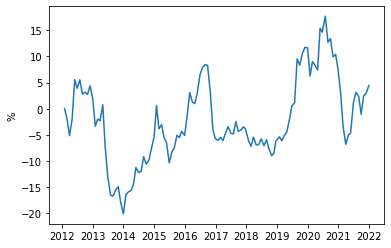

In [27]:
# Plot of cumulative returns (in %)
mean_list_1 = []
newval = 1
for meanval in monthly_mean_ret:
    newval = newval * (1 + meanval)
    mean_list_1.append((newval-1)*100)
plt.plot(model_swap_rates['date'].loc[0:], mean_list_1)
plt.ylabel('%')
#plt.title('Cumulative returns 09/2011 - 12/2021')
#plt.savefig('final_subp_cir_cobyla_cumu_5bps_mod.eps')

## HAC robust standard errors with 1 lag and corresponding t-stat, skewness and kurtosis<br> Plotting and calculating autocorrelation (serial correlation) coefficients ##

In [28]:
# Non-corrected t-statistic for comparison
stats.ttest_1samp(monthly_mean_ret, popmean=0, axis=None)

Ttest_1sampResult(statistic=0.29413002132916294, pvalue=0.7691709747648418)

In [29]:
# Test statistics with HAC robust standard errors
mkt_data = pd.DataFrame(monthly_mean_ret, columns=['rets'])
#one = np.ones(len(monthly_mean_ret))
mkt_data['one'] = 1
model = sm.ols( formula = 'rets ~ one',data = mkt_data).fit(cov_type='HAC', cov_kwds={'maxlags': 1}, use_t=True)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   rets   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                   0.07869
Date:                Sun, 10 Jul 2022   Prob (F-statistic):              0.780
Time:                        23:51:01   Log-Likelihood:                 255.95
No. Observations:                 120   AIC:                            -509.9
Df Residuals:                     119   BIC:                            -507.1
Df Model:                           0                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0004      0.001      0.281      0.780      -0.002       0.003
one            0.0004      0.001      0.281      0.780      -0.002       0.003
==============================================================================
Omnibus:                        2.728   Durbin-Watson:                   1.781
Prob(Omnibus):                  0.256   Jarque-Bera (JB):                2.689
Skew:                           0.022   Prob(JB):                        0.261
Kurtosis:                       3.732   Cond. No.                     7.84e+15
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 1 lags and without small sample correction
[2] The smallest eigenvalue is 3.91e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

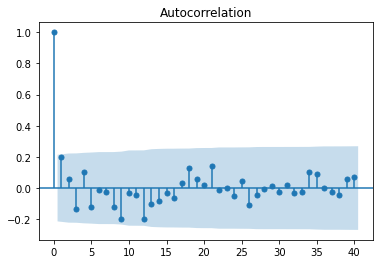

<Figure size 432x288 with 0 Axes>

In [34]:
#Plotting autocorrelation function
fig = tsaplots.plot_acf(monthly_mean_ret, lags=40)
plt.show()
#plt.savefig('final_subp_cir_cobyla_5bps_autocorr_mod.eps')

In [35]:
from statsmodels.tsa import stattools
# x = 1-D array
# Yield normalized autocorrelation function of number lags
autocorr = stattools.acf(monthly_mean_ret)

# Get autocorrelation coefficient at lag = 1
autocorr_coeff = autocorr[1]
autocorr_coeff

C:\Users\Miro_\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:657: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  warnings.warn(
C:\Users\Miro_\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


0.19648431479539785

## Testing autocorrelation with Durbin-Watson and Breusch-Godfrey. Not separately testing heteroskedasticity with Breusch-Pagan or other tests ##

In [36]:
import statsmodels.stats.stattools as sm_tools
print(sm_tools.durbin_watson(model.resid))

1.6049625292116807


In [37]:
from statsmodels.stats.stattools import durbin_watson
durbin_watson(model.resid)

1.6049625292116807

In [38]:
#FINAL SUBP CIR COBYLA 5BPS CORRECT OISDF MOD
import statsmodels.stats.diagnostic as dg

#perform Breusch-Godfrey test at order p
print(dg.acorr_breusch_godfrey(model, nlags=40))

(36.37741010563191, 0.6341012557586092, 0.8211589489419803, 0.7341575076074034)


## Histograms of returns ##

Text(0, 0.5, 'Density')

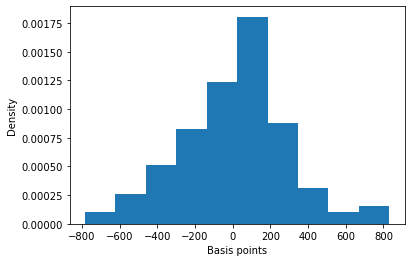

In [31]:
# Plotting histogram of returns
mean_list_hist = [ele*bpsmult for ele in monthly_mean_ret] 
plt.hist(mean_list_hist, density=True)
plt.xlabel('Basis points')
plt.ylabel('Density')
#plt.savefig('final_densityHist_subp_cir_cobyla_5bps_mod.eps')

Text(0.5, 0, 'Basis points')

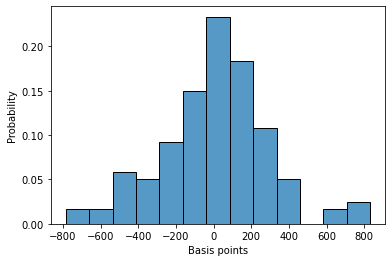

In [33]:
p = sns.histplot(data=mean_list_hist, stat='probability')
p.set_xlabel('Basis points')
#p.figure.savefig('final_probaHist_subp_cir_cobyla_5bps_mod.eps')

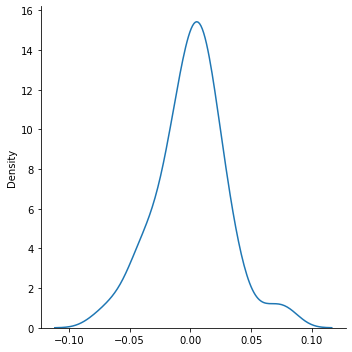

In [32]:
# Plotting continuous return distribution
sns.displot(data=monthly_mean_ret, kind="kde")

### Monthly excess returns to excel ###

In [43]:
monthly_mean_ret_df = pd.DataFrame(dates, columns=['dates'])
monthly_mean_ret_df['returns'] = monthly_mean_ret
monthly_mean_ret_df

,dates,returns
0,2015-01,-0.000000
1,2015-02,0.095792
2,2015-03,-0.013896
3,2015-04,0.062438
4,2015-05,0.020722
...,...,...
79,2021-08,-0.000726
80,2021-09,0.028329
81,2021-10,-0.041405
82,2021-11,-0.012727


In [44]:
monthly_mean_ret_df.to_excel('final_excreturns_subperiod_cir_cobyla_5bps_mod.xlsx')

## OTHER ##

In [ ]:
'''
from dateutil.parser import parse
xls_tied = pd.ExcelFile('smith_test.xlsx')

swap = xls_tied.parse('swap')
ois = xls_tied.parse('ois')
libor = xls_tied.parse('libor')
data_test = xls_tied.parse('testaus')

paiva = parse('2021-03-01')
a_val = vn.valuate_float(paiva, 0.005, libor, ois, swap, 3, 3, 24, 100000000, 3, 3, "Act/360", "Act/360")
b_val = vn.valuate_fixed(paiva, 0.0526, ois, 3, 24, 100000000, 3, "Act/360")
'''

In [ ]:
'''
model = sm.ols( formula = 'rets ~ one',data = mkt_data).fit()
new = model.get_robustcov_results(cov_type='HAC',maxlags=1)
T_test = mean_list.t_test(new.params) 
print(T_test)
'''

In [ ]:
'''
mispricings = model_swap_rates.loc[:,'USD1YS':] - data1_swap_trade.loc[4:,'USD1YS':].reset_index().drop(['index'],axis=1)
mispricings[20:].plot()
'''

In [ ]:
'''
smf.tsa.acf(mean_list)
'''

In [11]:
book_dict

{'First book': Empty DataFrame
 Columns: [date, Trade type, M from open, Maturity, M to float, M to fixed, S of model, S of trade, S of H1, S of H10, Latest 3ML, Previous total dirty, Previous trade dirty, Previous H1 dirty, Previous H10 dirty, Nominal trade, Nominal H1, Nominal H10, Weight H1, Weight H10, Initial mispricing, Current mispricing, Current total dirty, Current trade dirty, Current H1 dirty, Current H10 dirty]
 Index: []
 
 [0 rows x 26 columns],
 Period('2012-01', 'M'):       date Trade type M from open Maturity M to float M to fixed  S of model  \
 0  2012-01      Payer           0        3          3          6    0.008855   
 
    S of trade  S of H1  S of H10  ...  Nominal H1 Nominal H10 Weight H1  \
 0     0.00599  0.00496   0.01941  ...   53.528533    50.86034  0.535285   
 
   Weight H10 Initial mispricing Current mispricing  Current total dirty  \
 0   0.508603           0.002865           0.002865                  0.0   
 
    Current trade dirty  Current H1 dirt